##### SHAP-XGB   
## Shapley Additive Explanation-XGB  
最后更新：2022.02.08 戴以恒  
当前版本：V1.2sym  
### 简介：  
使用SHAP分析某一目标特征对标签值的影响  
### 更新记录：  
V1.0：框架的搭建
>sym:加入对相关性的考虑，每一个特征分析时删掉其他相关性高的特征
>V1.1:sym把相关性考虑进去，主要是跳出相关性矩阵中最相关两个特征，比较他们的特征重要性，并删掉不重要的那个，依次迭代
>V1.2:sym指定某个特征并把与他特别相关的其他特征删去后，得一个shap图
V1.3sym:另加入inputX2和title2，作为小数据集，使X1和title1中选取的特征可以逐一添加到X2和title2中

V1.4sym:指定计算shap的特征矩阵

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import gc
c_time = time.strftime("%Y%m%d_%H%M%S", time.localtime())
c_time_m = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

In [2]:
# 参数
# ======== System Setup ========
Version = 'V1.4sym'
EPOCH = 120
REPEAT_ROUND = 1
CORE_NUM = 24
# 确保EPOCH*REPEAT_ROUND是CORE_NUM的整数倍
TRAIN_TEST_SPLIT = 0.85
# ======== Fit Data Input ========
S_N = 856
F_N = 767
INPUT_X = 'Features_'+str(S_N)+'_'+str(F_N)+'.csv'
INPUT_Y = 'Values_True_ln_'+str(S_N)+'.csv'
INPUT_TITLE = 'Title_'+str(F_N)+'.csv'
INPUT_SMILES = 'Smiles_'+str(S_N)+'.csv'
RECORD_NAME = 'Record_AFS_'+Version+'_'+c_time+'.txt'

F_N2=6
INPUT_X2='Features_'+str(S_N)+'_'+str(F_N2)+'.csv'
INPUT_TITLE2 = 'Title_'+str(F_N2)+'.csv'

In [3]:
import shap
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import model_selection
import joblib
from multiprocessing import Pool

In [4]:
import os
from pathlib import Path

X = np.loadtxt(INPUT_X, delimiter=',')
y = np.loadtxt(INPUT_Y)
title = np.loadtxt(INPUT_TITLE, dtype=str, delimiter=',', comments='!')
smiles = np.loadtxt(INPUT_SMILES, dtype=str, delimiter=',', comments='!')
X2=np.loadtxt(INPUT_X2, delimiter=',')
title2 = np.loadtxt(INPUT_TITLE2, dtype=str, delimiter=',', comments='!')
# f1 = open(RECORD_NAME, 'w')
# f1.write('SHAP-XGB_cov-sel '+Version+'\n\n')
# f1.write('Generation time: '+time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())+'\n\n\n')

In [5]:
title2

array(['Max Conju-Distance (MFF-Conju)',
       'Conju-PEOE-Charge-Maximum (MFF-Conju)',
       'Conju-Atomic-LogP-Minimum (MFF-Conju)',
       'Conju-Atomic-MR-Maximum (MFF-Conju)', 'ET(30) (Solvent)',
       'Wavelength (Exp nm)'], dtype='<U37')

In [6]:
clf = XGBRegressor(n_estimators=150, learning_rate=0.025, max_depth=13, verbosity=0, booster='gbtree', 
                   reg_alpha=np.exp(-6.788644799030888), reg_lambda=np.exp(-7.450413274554533), gamma=np.exp(-5.374463422208394), 
                   subsample=0.5, objective= 'reg:squarederror', n_jobs=1)
paras = clf.get_params()

In [7]:
def XGB_Fit(X, y, X_train, y_train, X_test, y_test, paras):
    clf_new = XGBRegressor()
    for k, v in paras.items():
        clf_new.set_params(**{k: v})
    # 拟合模型
    clf_new.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=150, verbose=False)
    # 计算损失
    y_pred = clf_new.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    shap_values = shap.TreeExplainer(clf_new).shap_values(X)
    temp = [mse, mae, r2, shap_values]
#     print('   MSE: %.5f' % mse, '  MAE: %.5f' % mae, '  R^2: %.5f' % r2)
    del y_pred
    return (temp, 'None')

In [8]:
titlelist=['Conju-Stru-VSA (MFF-Conju)'
#     'Kappa3',
#            'Chi3n',
#            'C=Cc1ccc(N)cc1',
#            'ccc(cc)N(c)c',
# 'Conju-Delta PEOE Charge (MFF-Conju)',
#             'Conju-Stru Wiener Index (MFF-Conju)',
# #             'ccc(cc)-c(c)c',
# #             'HallKierAlpha',
#             'Conju-Branch Index (MFF-Conju)',
#             'FractionCSP3',
#     'Conju-Part-Wt (MFF-Conju)'
]

Conju-Stru-VSA (MFF-Conju)
0.95
6
[ 1.00000000e+01  1.90428965e-01  6.72085573e-02 -1.55355891e+00
  1.58279032e+01  1.33577840e+02  2.34750496e+02]
['Max Conju-Distance (MFF-Conju)' 'Conju-PEOE-Charge-Maximum (MFF-Conju)'
 'Conju-Atomic-LogP-Minimum (MFF-Conju)'
 'Conju-Atomic-MR-Maximum (MFF-Conju)' 'ET(30) (Solvent)'
 'Wavelength (Exp nm)' 'Conju-Stru-VSA (MFF-Conju)']
dellist []
[]
[ 1.00000000e+01  1.90428965e-01  6.72085573e-02 -1.55355891e+00
  1.58279032e+01  1.33577840e+02  2.34750496e+02]
['Max Conju-Distance (MFF-Conju)' 'Conju-PEOE-Charge-Maximum (MFF-Conju)'
 'Conju-Atomic-LogP-Minimum (MFF-Conju)'
 'Conju-Atomic-MR-Maximum (MFF-Conju)' 'ET(30) (Solvent)'
 'Wavelength (Exp nm)' 'Conju-Stru-VSA (MFF-Conju)']
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
Round 97 Begin:
Std= 0.1408780288153879


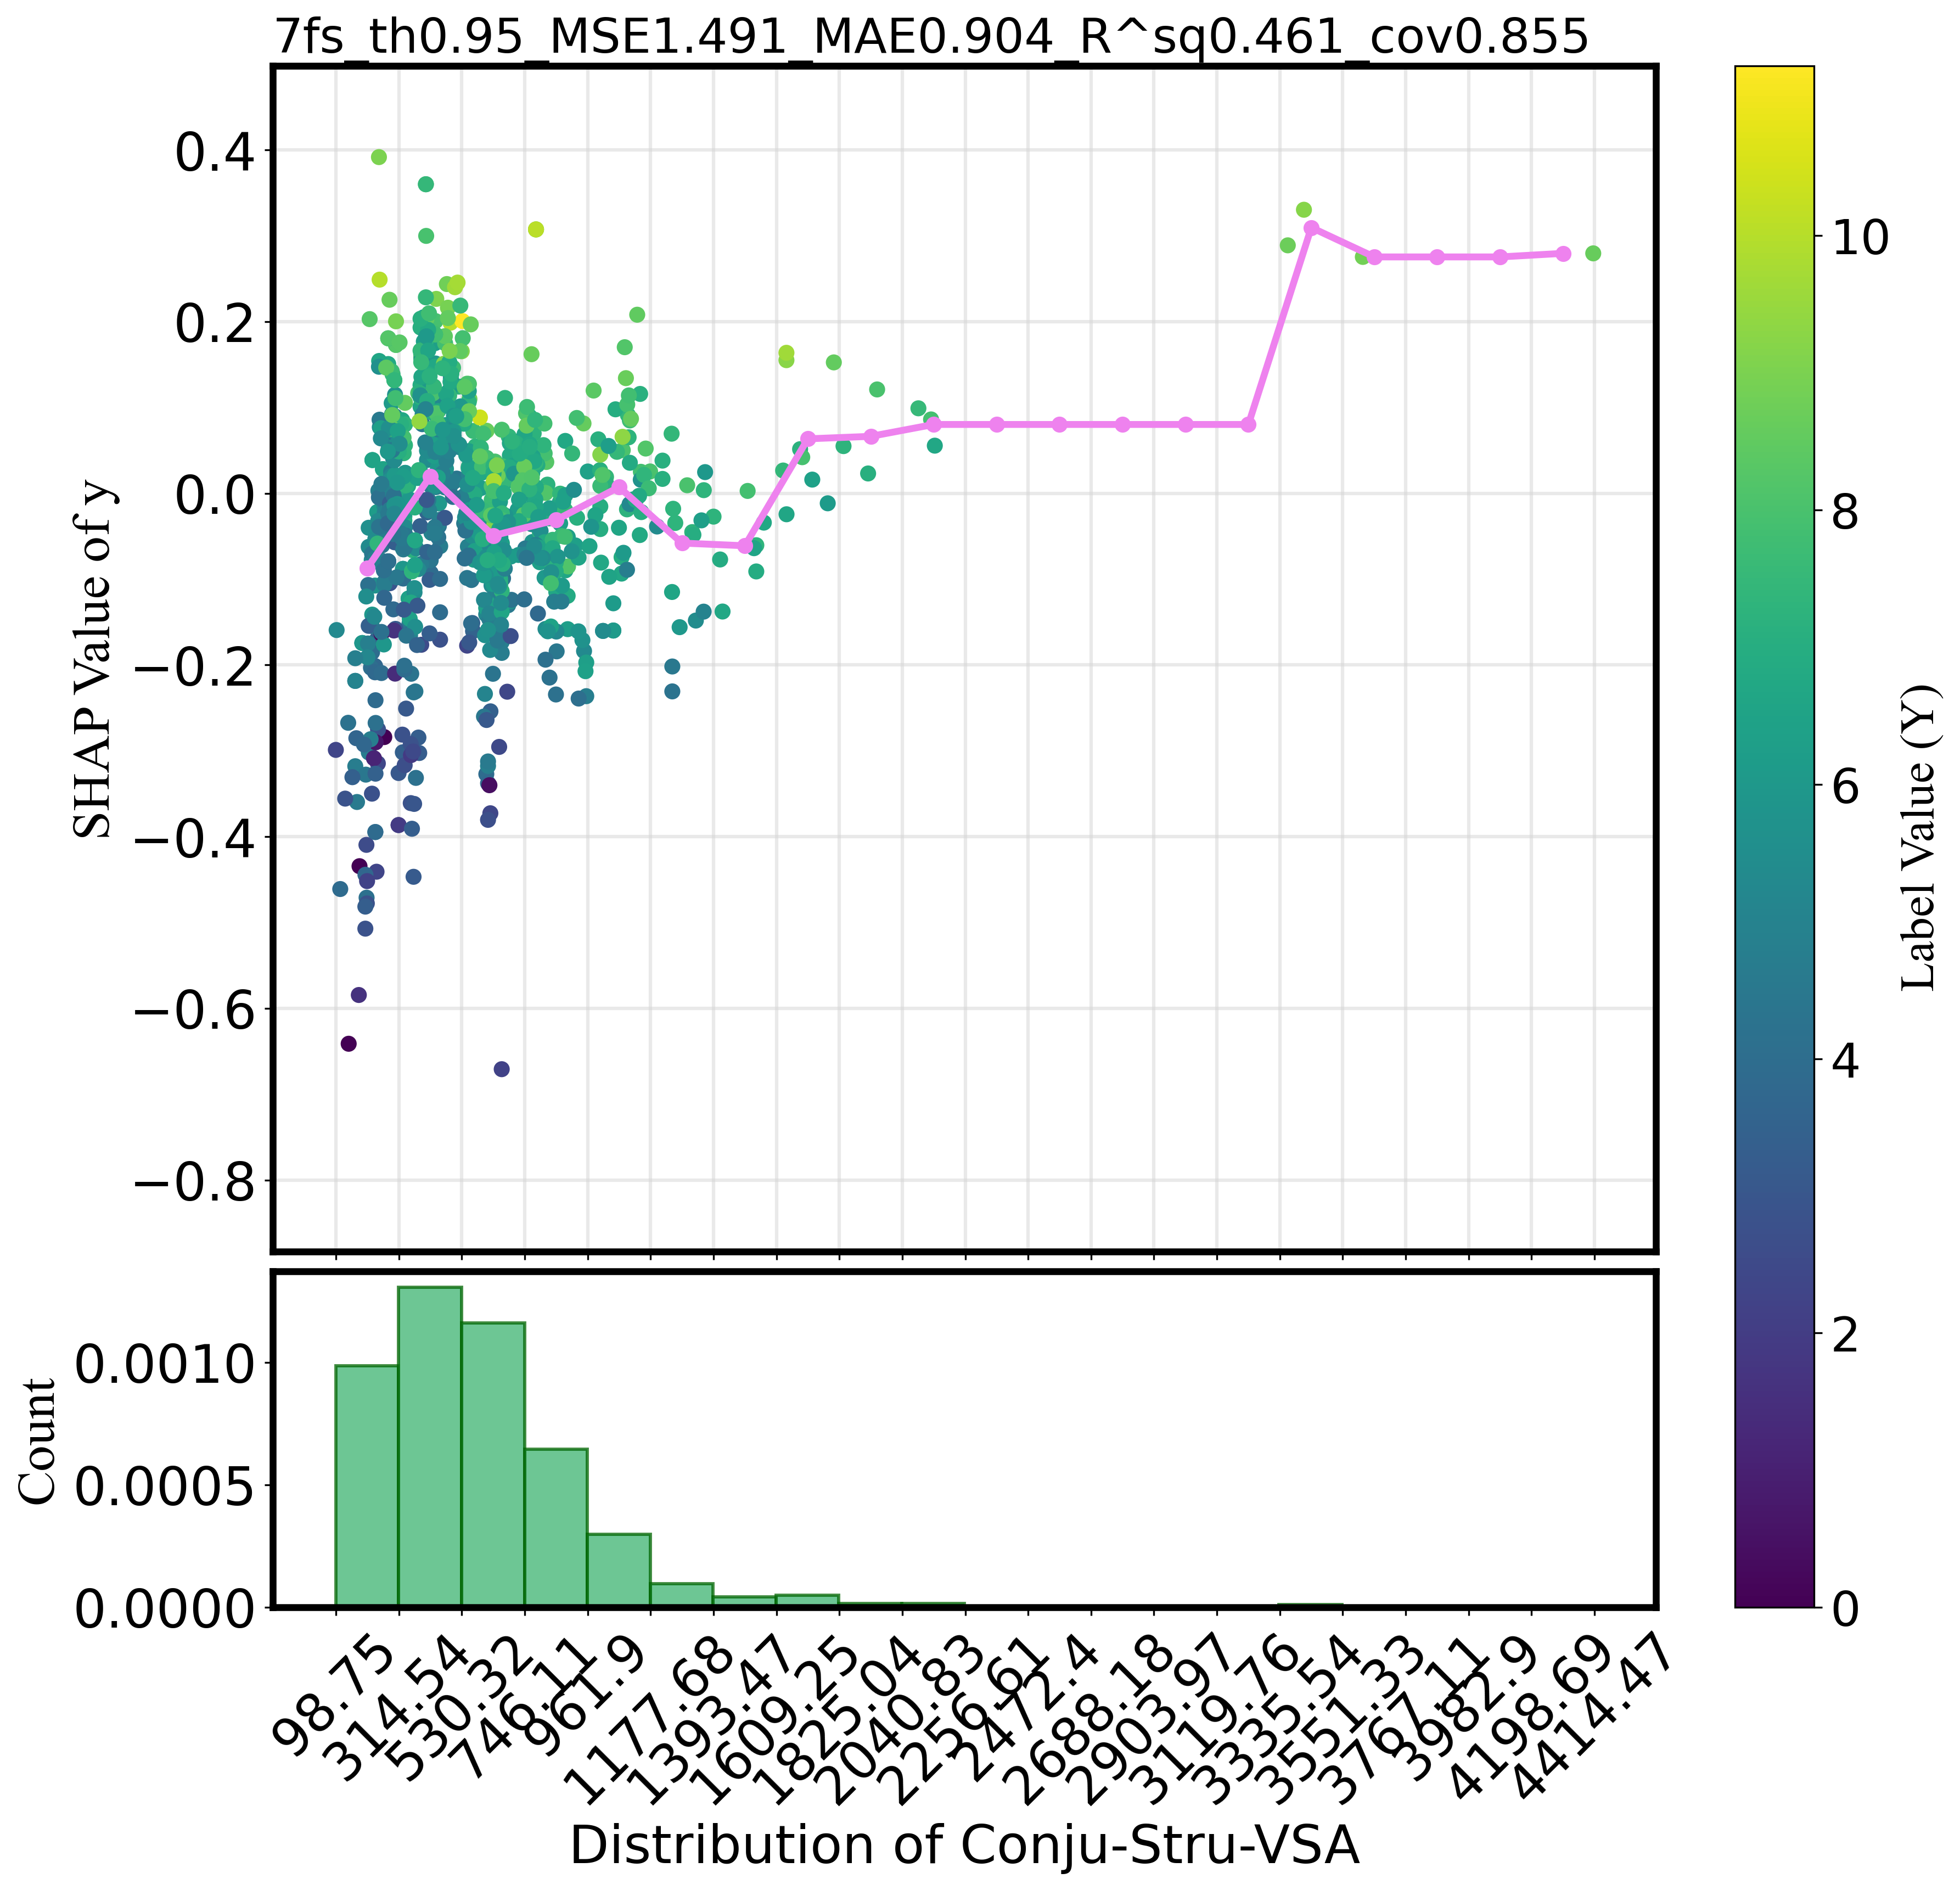

In [9]:
for SelectedFeature in titlelist:
    print(SelectedFeature)
    
# SelectedFeature='Chi3n'
    DIR = 'SHAP-XGB_cov-sel'+Version+'_'+c_time
    DIR=DIR+SelectedFeature
    os.mkdir(DIR)
    RECORD_NAME = Path('.', DIR, RECORD_NAME)
    covthreslist=np.linspace(0.95,0.95,1)
    for covthres in covthreslist:
    #     covthres=0.2
        print(covthres)
        SelFeatindex=np.where(title==SelectedFeature)
        X = np.loadtxt(INPUT_X, delimiter=',')
        X2 = np.loadtxt(INPUT_X2, delimiter=',')
        title = np.loadtxt(INPUT_TITLE, dtype=str, delimiter=',', comments='!')
        title2 = np.loadtxt(INPUT_TITLE2, dtype=str, delimiter=',', comments='!')
        X2c = X2.copy()
        print(len(X2c[0]))
        b=X.copy()
        b2=b[:,SelFeatindex[0][0]]
        b2=b2.reshape(856,1)
        X2c=np.append(X2c,b2,axis=1)

        t=title2.copy()
        t2=np.append(t,[SelectedFeature],axis=0)
        print(X2c[0])
        print(t2)
        SelFeatindex2=np.where(t2==SelectedFeature)
        
        m = X2c.copy()
        mse_list = []
        mae_list = []
        r2_list = []
        for i in range(m.shape[1]):
            m[:, i] = (m[:, i]-np.mean(m[:, i]))/np.std(m[:, i])
        cov_m = np.cov(m, rowvar=False)
        data = []
        for i in range(cov_m.shape[0]):
            for j in range(cov_m.shape[1]-i-1):
                data.append([i, j+1+i, cov_m[i, j+1+i]])
        data_m = np.array(data)
        permu = np.argsort(-np.abs(data_m[:, -1]))
        data_m_p = data_m[permu, :]
#         print(data_m_p)
        dellist=[]
        delnum=0
        for i in range(len(data_m)):
            if SelFeatindex2 in data_m[i] and data_m[i][2]>=covthres:
                dellist.append(data_m[i])
                delnum=delnum+1
        print('dellist',dellist)
        list1=[x[0] for x in dellist]
        list2=[x[1] for x in dellist]
        list1.extend(list2)
        for j in range (delnum):
            list1.remove(SelFeatindex2[0][0])
        #想要定制数据集，在这里改，找到欲指定删除的特征需要，减一后写到下面
#         list1.append(6)

        X_ = np.delete(X2c.copy(), list1, axis=1)
        title_ = np.delete(t2, list1, axis=0)
        print(list1)
        print(X_[0])
        print(title_)
        
        r_l = []
        point = round(X.shape[0]*TRAIN_TEST_SPLIT)
        for _ in range(int(EPOCH/CORE_NUM)):
            print('Round', CORE_NUM*(_)+1, 'Begin:')
            pool = Pool(CORE_NUM)
            for __ in range(CORE_NUM):
                permutation = np.random.permutation(y.shape[0])
                train_idx = permutation[:point]
                test_idx = permutation[point:]
                X_train = X_[train_idx, :]
                y_train = y[train_idx]
                X_test = X_[test_idx, :]
                y_test = y[test_idx]
                r = pool.apply_async(XGB_Fit, args=(X_, y, X_train, y_train, X_test, y_test, paras,))
                r_l.append(r)
            pool.close()
            pool.join()
        shap_m = np.zeros((S_N, len(title_)))
        for i in range(len(r_l)):
            r = r_l[i]
            results = r.get()
            temp = results[0]
            mse = temp[0]
            mae = temp[1]
            r2 = temp[2]
            mse_list.append(mse)
            mae_list.append(mae)
            r2_list.append(r2)
            shap_m += temp[3]    
        shap_m = shap_m/len(r2_list)
        mse=np.mean(mse_list)
        mae=np.mean(mae_list)
        r2=np.mean(r2_list)

        outputstr='_MSE'+str(round(mse,3))+'_MAE'+str(round(mae,3))+'_R^sq'+str(round(r2,3))+'_cov'+str(round(data_m_p[0, 2],3))
        SelFeatindex2=np.where(title_==SelectedFeature)
        from math import floor
        INTERVAL_1D = 20
        f_name = SelectedFeature
        if f_name[-1] == ')':
            for j in range(len(f_name)):
                index = len(f_name) - j - 1
                if f_name[index] == '(':
                    break
            f_name = f_name[:index-1]
        id_1d = SelFeatindex2[0][0]
        X=X_
        if max(X[:, id_1d])>0:
            ii = (max(X[:, id_1d])*1.001-min(X[:, id_1d]))/INTERVAL_1D
        else:
            ii = (max(X[:, id_1d])*0.999-min(X[:, id_1d]))/INTERVAL_1D
        fig = plt.figure(figsize=(12, 12), dpi=300)
        ax = fig.add_axes([0.11, 0.29, 0.70, 0.60])
        plt.title(str(len(title_))+'fs_th'+str(covthres)+outputstr,loc='left',fontsize= 21)
        #     plt.suptitle('delete'+str(list(set(title).difference(set(title_)))),  fontsize=12)
        ax2 = fig.add_axes([0.11, 0.11, 0.70, 0.17])
        ax_bar = fig.add_axes([0.85, 0.11, 0.04, 0.78])
        x_idx = []
        x_inter = [min(X[:, id_1d])]
        x_ticks_blank = ['']
        x_ticks = [str(round(min(X[:, id_1d]), 2))]
        y_mean_data = np.zeros((INTERVAL_1D, 1))
        y_mean_count = np.zeros((INTERVAL_1D, 1))
        for j in range(X.shape[0]):
            if floor((X[j, id_1d]-min(X[:, id_1d]))/ii) == INTERVAL_1D:
                print(X[j, id_1d], X[j, id_1d]-min(X[:, id_1d]), ii, (X[j, id_1d]-min(X[:, id_1d]))/ii)
            y_mean_data[floor((X[j, id_1d]-min(X[:, id_1d]))/ii), 0] += shap_m[j, id_1d]
            y_mean_count[floor((X[j, id_1d]-min(X[:, id_1d]))/ii), 0] += 1
        for j in range(INTERVAL_1D):
            x_idx.append(ii*(0.5+j)+min(X[:, id_1d]))
            x_inter.append(ii*j+ii+min(X[:, id_1d]))
            x_ticks.append(str(round(ii*(j+1)+min(X[:, id_1d]), 2)))
            x_ticks_blank.append('')
            if y_mean_count[j, 0] != 0:
                y_mean_data[j, 0] /= y_mean_count[j, 0]
            else:
                y_mean_data[j, 0] = y_mean_data[j-1, 0]
        x_data = X[:, id_1d].flatten().tolist()
        y_data = shap_m[:, id_1d].flatten().tolist()
        sc = ax.scatter(x_data, y_data, c=y, cmap='viridis', marker='o', zorder=5)
        ax.plot(x_idx, y_mean_data, color='#EE82EE', linewidth=3, zorder=10, marker='o')
        ax.set_ylim(min(y_data)-0.2*(max(y_data)-min(y_data)), max(y_data)+0.1*(max(y_data)-min(y_data)))
        plt.tick_params(labelsize=21)
        ax2.hist(x_data, INTERVAL_1D, density=1, facecolor='#3CB371', edgecolor='#006400', alpha=0.75, linewidth=1.4)
        ax2.set_xlabel('Distribution of '+f_name, fontsize=23)
        ax.set_ylabel('SHAP Value of y', fontsize=23, fontdict={'family' : 'Times New Roman'})
        ax2.set_ylabel('Count', fontsize=23,fontdict={'family' : 'Times New Roman'})
        ax.set_xticks(x_inter)
        ax.set_xticklabels(x_ticks_blank)
        ax2.set_xticks(x_inter)
        ax2.set_xticklabels(x_ticks, rotation = 45, fontsize=15)
        ax.grid(which='major', color='#D5D5D5', alpha=0.5, zorder=2,linewidth = 1.5)
        ax.spines['bottom'].set_linewidth(3);###设置底部坐标轴的粗细
        ax.spines['left'].set_linewidth(3);####设置左边坐标轴的粗细
        ax.spines['right'].set_linewidth(3);###设置右边坐标轴的粗细
        ax.spines['top'].set_linewidth(3);####设置上部坐标轴的粗细
        ax2.spines['bottom'].set_linewidth(3);###设置底部坐标轴的粗细
        ax2.spines['left'].set_linewidth(3);####设置左边坐标轴的粗细
        ax2.spines['right'].set_linewidth(3);###设置右边坐标轴的粗细
        ax2.spines['top'].set_linewidth(3);####设置上部坐标轴的粗细
        ax.tick_params(labelsize=23)
        ax2.tick_params(labelsize=23)
        cb = plt.colorbar(sc, cax=ax_bar)
        cb.set_label('Label Value (Y)', fontsize=21,fontdict={'family' : 'Times New Roman'})
        cb.ax.tick_params(labelsize=21) 

        save_name = SelectedFeature+'SHAP_Matrix_'+str(len(title_))+'fs_th'+str(round(covthres,3))+'_'+c_time+'.csv'
        save_name = Path('.', DIR, save_name)
        np.savetxt(save_name, shap_m, fmt='%s', delimiter=',')


        save_nameX = SelectedFeature+'Feature_Matrix_'+str(len(title_))+'fs_th'+str(round(covthres,3))+'_'+c_time+outputstr+'.csv'
        save_nameX = Path('.', DIR, save_nameX)
        np.savetxt(save_nameX, X_, fmt='%s', delimiter=',')

        save_nametitle = SelectedFeature+'Title_'+str(len(title_))+'fs_th'+str(round(covthres,3))+'_'+c_time+'.csv'
        save_nametitle = Path('.', DIR, save_nametitle)
        np.savetxt(save_nametitle, title_, fmt='%s', delimiter=',')

        symsave1= np.column_stack((x_data, y_data,y)) 
        save_name2 =  SelectedFeature+'_Scatter_'+str(len(title_))+'fs_th'+str(round(covthres,3))+'_'+c_time+outputstr+'s.csv'  
        save_name2 = Path('.', DIR, save_name2)
        np.savetxt(save_name2,symsave1, fmt='%s', delimiter=',', comments='!')

        symsave2= np.column_stack((x_idx, y_mean_data))
        save_name3 =  SelectedFeature+'_Plot_'+str(len(title_))+'fs_th'+str(round(covthres,3))+'_'+c_time+outputstr+'p.csv'  
        save_name3 = Path('.', DIR, save_name3)
        np.savetxt(save_name3,symsave2, fmt='%s', delimiter=',', comments='!')

        save_name = SelectedFeature+str(len(title_))+'fs_th'+str(round(covthres, 2))+'_'+outputstr+'.png'
        save_name = Path('.', DIR, save_name)
        plt.savefig(save_name)
        print('Std=',np.std(y_data))